## Import the dependencies

In [69]:
#!pip install contractions

In [70]:
import nltk
#nltk.download('all')

In [71]:
#!python -m spacy download es_core_news_sm

In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from spacy.tokenizer import Tokenizer
from sklearn.model_selection import train_test_split
import pandas as pd
import spacy
import re
import numpy as np
import string
import matplotlib.pyplot as plt
import csv
import contractions
from nltk.corpus import stopwords
from spacy.tokenizer import Tokenizer
import random
from tqdm import tqdm
import math
import warnings
warnings.filterwarnings("ignore")

In [73]:
pd.set_option('display.max_colwidth', None) # mostrar todo el texto de una celda

In [74]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using",device)

Using cuda


## CARGAR EL DATASET

In [75]:
# df1 = pd.read_csv("D:/SIS-421/textos/es_test.csv",encoding='latin-1',usecols=['summary','text'])
# df2 = pd.read_csv("D:/SIS-421/textos/es_train.csv",encoding='latin-1', usecols=['summary','text'])

In [76]:
df1 = pd.read_csv("D:/SIS-421/textos/test_half2.csv",encoding='utf-8',usecols=['summary','text']) 
df2 = pd.read_csv("D:/SIS-421/textos/train_half2.csv",encoding='utf-8', usecols=['summary','text'])

In [77]:
df1.head(1) # muestra el primer registro de test

,text,summary
0,"Tráiler de 'Hasta siempre, hijo mío' En Hasta siempre, hijo mío, Wang Xiaoshuai -el realizador de La bicicleta de Pekín y Secretos de Shanghái- describe la vida de un matrimonio durante tres décadas en las que sufre diversas vicisitudes y desgracias. La película no está contada de forma lineal, sino que se estructura con numerosísimos flashbacks en sus 185 minutos. En su tramo final, el director revela un secreto de familia y otras sorpresas sentimentales que pillan con el paso cambiado a público y protagonistas del drama, mientras deja fluir el trabajo de la pareja protagonista, los actores Wang Jingchun, que encarna a un hombre bondadoso aunque con sus miserias y su alcoholismo, y Yong Mei -actriz que aparecía en The Assassin-, como una mujer contenida, a veces sobrepasada, siempre sincera. Gracias a sus trabajos lograron los Osos de Plata a Mejor Actor y Actriz de la pasada Berlinale y aquí tenemos su tráiler antes de que llegue a las salas españoles el próximo 27 de septiembre.","La película de Wang Xiaoshuai, que se estrena el 27 de septiembre, obtuvo los premios a mejor actor y mejor actriz en la última Berlinale"


In [78]:
# filas y colunmas
df1.shape 

(580, 2)

In [79]:
df2.head(1) # muestra el primer registro de train

,text,summary
0,"Interior va a sufrir de nuevo un cambio de primer orden en su organigrama con el relevo de dos de los tres viceconsejeros que nombró Rodolfo Ares al llegar a la cartera hace poco más de dos años. El primero, el del viceconsejero de Administración y Servicio, Ernesto Martínez de Lahidalga, fue aprobado por el Consejo de Gobierno en su reunión de ayer. El segundo, el del viceconsejero de Seguridad, Rafael Iturriaga, ya está acordado también y se materializará en la reunión del Ejecutivo del próximo martes, según ha podido saber EL PAÍS. Esta última sustitución tiene un alto contenido político, ya que la persona elegida para hacerse cargo del puesto es el candidato socialista a la Diputación de Guipúzcoa, Miguel Buen. De los tres viceconsejeros nombrados por Ares permanecerá así en su cargo el de Interior, Raúl Fernández de Arroyabe. Medio Ambiente releva también a su viceconsejera Nieves Terán Los dos relevos llegan en un momento de tensión creciente en el departamento que acusan también otros niveles de menor responsabilidad. Y, junto a otro realizado ayer en Medio Ambiente, coinciden igualmente con el desastre electoral del PSE, que ha dejado a muchos de sus candidatos en la estacada, y con la reclamación de cambios desde las filas del partido y del propio Gobierno, como es el caso de la consejera de Empleo, Gemma Zabaleta. Lo que piden esas voces es, sobre todo, mayor perfil político propio, es decir, más partido en los altos cargos del Ejecutivo. Todo indica que habrá más relevos y que afectarán a varios departamentos. Respecto a cambios en las filas del propio Gobierno, el lehendakari, Patxi López, los ha descartado públicamente, al tiempo que se declaraba plenamente satisfecho de la gestión de todos sus integrantes. La portavoz, Idoia Mendia, se remitió ayer de nuevo a esa afirmación. El Gobierno se esforzó ayer en despojar los cambios de toda sombra de desavenencias. Mendia atribuyó el relevo de Martínez de Lahidalga a ""razones personales"", precisó que se realizó ""de común acuerdo"" con el departamento y reveló que aquel, en su día portavoz del sindicato policial Erne, remitió recientemente una carta al consejero expresándole ""su deseo de terminar su andadura en el Gobierno"". ""Hasta donde me consta, la relación es muy buena"", sostuvo Mendia, quien desmintió la existencia de desavenencias entre el hasta ahora viceconsejero y Ares. La portavoz sugirió que la decisión de Martínez de Lahidalga no es un fruto de la última semana. Fuentes de Interior negaron de modo tajante cualquier relación entre esta marcha y el conflicto en la Ertzaintza y consideraron el ecuador del mandato de un Gobierno como momento adecuado para realizar este tipo de cambios. Martínez de Lahidalga fue sustituido ayer mismo por la hasta ahora directora de Gestión Económica e Infraestructuras del departamento, Nélida Santos. Ares deberá dar explicaciones del cambio en el Parlamento, donde EA anunció ya que solicitará su comparecencia. El otro cambio anunciado ayer afecta a la viceconsejería de Medio Ambiente. Su hasta ahora responsable, Nieves Terán, cuyo cese también atribuyó Mendia a razones personales, será sustituida por Arantza Leturiondo, hasta ahora directora de Política Territorial en el Ayuntamiento de Basauri. El Gobierno cambió ya en su primer año de mandato a 22 altos cargos nombrados en la nueva etapa -seis viceconsejeros, 12 directores y cinco asesores-, que calificó como ""ajustes lógicos"" en cualquier organización a la que se somete por primera vez en 30 años a un relevo integral en su estructura. * Este artículo apareció en la edición impresa del Miércoles, 8 de junio de 2011",Miguel Buen reemplazará a Rafael Iturriaga como responsable de Seguridad


In [80]:
df2.shape 

(3627, 2)

In [81]:
train_df = df2.copy() # copia de df2
test_df = df1.copy()

In [82]:
# Nro de Elementos, Nro de valores unicos, valor mas frecuente(top) y su frecuencia (freq)
train_df.describe() 

,text,summary
count,3627,3627
unique,3627,3625
top,"Interior va a sufrir de nuevo un cambio de primer orden en su organigrama con el relevo de dos de los tres viceconsejeros que nombró Rodolfo Ares al llegar a la cartera hace poco más de dos años. El primero, el del viceconsejero de Administración y Servicio, Ernesto Martínez de Lahidalga, fue aprobado por el Consejo de Gobierno en su reunión de ayer. El segundo, el del viceconsejero de Seguridad, Rafael Iturriaga, ya está acordado también y se materializará en la reunión del Ejecutivo del próximo martes, según ha podido saber EL PAÍS. Esta última sustitución tiene un alto contenido político, ya que la persona elegida para hacerse cargo del puesto es el candidato socialista a la Diputación de Guipúzcoa, Miguel Buen. De los tres viceconsejeros nombrados por Ares permanecerá así en su cargo el de Interior, Raúl Fernández de Arroyabe. Medio Ambiente releva también a su viceconsejera Nieves Terán Los dos relevos llegan en un momento de tensión creciente en el departamento que acusan también otros niveles de menor responsabilidad. Y, junto a otro realizado ayer en Medio Ambiente, coinciden igualmente con el desastre electoral del PSE, que ha dejado a muchos de sus candidatos en la estacada, y con la reclamación de cambios desde las filas del partido y del propio Gobierno, como es el caso de la consejera de Empleo, Gemma Zabaleta. Lo que piden esas voces es, sobre todo, mayor perfil político propio, es decir, más partido en los altos cargos del Ejecutivo. Todo indica que habrá más relevos y que afectarán a varios departamentos. Respecto a cambios en las filas del propio Gobierno, el lehendakari, Patxi López, los ha descartado públicamente, al tiempo que se declaraba plenamente satisfecho de la gestión de todos sus integrantes. La portavoz, Idoia Mendia, se remitió ayer de nuevo a esa afirmación. El Gobierno se esforzó ayer en despojar los cambios de toda sombra de desavenencias. Mendia atribuyó el relevo de Martínez de Lahidalga a ""razones personales"", precisó que se realizó ""de común acuerdo"" con el departamento y reveló que aquel, en su día portavoz del sindicato policial Erne, remitió recientemente una carta al consejero expresándole ""su deseo de terminar su andadura en el Gobierno"". ""Hasta donde me consta, la relación es muy buena"", sostuvo Mendia, quien desmintió la existencia de desavenencias entre el hasta ahora viceconsejero y Ares. La portavoz sugirió que la decisión de Martínez de Lahidalga no es un fruto de la última semana. Fuentes de Interior negaron de modo tajante cualquier relación entre esta marcha y el conflicto en la Ertzaintza y consideraron el ecuador del mandato de un Gobierno como momento adecuado para realizar este tipo de cambios. Martínez de Lahidalga fue sustituido ayer mismo por la hasta ahora directora de Gestión Económica e Infraestructuras del departamento, Nélida Santos. Ares deberá dar explicaciones del cambio en el Parlamento, donde EA anunció ya que solicitará su comparecencia. El otro cambio anunciado ayer afecta a la viceconsejería de Medio Ambiente. Su hasta ahora responsable, Nieves Terán, cuyo cese también atribuyó Mendia a razones personales, será sustituida por Arantza Leturiondo, hasta ahora directora de Política Territorial en el Ayuntamiento de Basauri. El Gobierno cambió ya en su primer año de mandato a 22 altos cargos nombrados en la nueva etapa -seis viceconsejeros, 12 directores y cinco asesores-, que calificó como ""ajustes lógicos"" en cualquier organización a la que se somete por primera vez en 30 años a un relevo integral en su estructura. * Este artículo apareció en la edición impresa del Miércoles, 8 de junio de 2011",Más de 3.000 seguidores escoltaron al equipo a un estadio lleno de camisetas azulgrana
freq,1,2


In [83]:
test_df.describe()

,text,summary
count,580,580
unique,576,578
top,"Especial Publicidad El amor por el teatro ha acompañado al actor italiano Corrado Tedeschi a lo largo de su vida. Un amor “que quita el aliento, pero que también lo regala”. Esta historia refleja los valores que defiende GEOX, que nos anima a vivir con intensidad a través de sus zapatos.",Un análisis de la actualidad internacional a través de artículos publicados en medios globales seleccionados y comentados por la revista CTXT
freq,5,2


In [84]:

# elimina filas que contengan valores nulos y duplicados en summary y text
train_df.dropna(inplace=True)
train_df.drop_duplicates(inplace=True,subset=['summary'])
train_df.drop_duplicates(inplace=True,subset=['text'])

In [85]:
train_df.describe() # Nro de Elementos, Nro de valores unicos, valor mas frecuente(top) y su frecuencia (freq)

,text,summary
count,3625,3625
unique,3625,3625
top,"Interior va a sufrir de nuevo un cambio de primer orden en su organigrama con el relevo de dos de los tres viceconsejeros que nombró Rodolfo Ares al llegar a la cartera hace poco más de dos años. El primero, el del viceconsejero de Administración y Servicio, Ernesto Martínez de Lahidalga, fue aprobado por el Consejo de Gobierno en su reunión de ayer. El segundo, el del viceconsejero de Seguridad, Rafael Iturriaga, ya está acordado también y se materializará en la reunión del Ejecutivo del próximo martes, según ha podido saber EL PAÍS. Esta última sustitución tiene un alto contenido político, ya que la persona elegida para hacerse cargo del puesto es el candidato socialista a la Diputación de Guipúzcoa, Miguel Buen. De los tres viceconsejeros nombrados por Ares permanecerá así en su cargo el de Interior, Raúl Fernández de Arroyabe. Medio Ambiente releva también a su viceconsejera Nieves Terán Los dos relevos llegan en un momento de tensión creciente en el departamento que acusan también otros niveles de menor responsabilidad. Y, junto a otro realizado ayer en Medio Ambiente, coinciden igualmente con el desastre electoral del PSE, que ha dejado a muchos de sus candidatos en la estacada, y con la reclamación de cambios desde las filas del partido y del propio Gobierno, como es el caso de la consejera de Empleo, Gemma Zabaleta. Lo que piden esas voces es, sobre todo, mayor perfil político propio, es decir, más partido en los altos cargos del Ejecutivo. Todo indica que habrá más relevos y que afectarán a varios departamentos. Respecto a cambios en las filas del propio Gobierno, el lehendakari, Patxi López, los ha descartado públicamente, al tiempo que se declaraba plenamente satisfecho de la gestión de todos sus integrantes. La portavoz, Idoia Mendia, se remitió ayer de nuevo a esa afirmación. El Gobierno se esforzó ayer en despojar los cambios de toda sombra de desavenencias. Mendia atribuyó el relevo de Martínez de Lahidalga a ""razones personales"", precisó que se realizó ""de común acuerdo"" con el departamento y reveló que aquel, en su día portavoz del sindicato policial Erne, remitió recientemente una carta al consejero expresándole ""su deseo de terminar su andadura en el Gobierno"". ""Hasta donde me consta, la relación es muy buena"", sostuvo Mendia, quien desmintió la existencia de desavenencias entre el hasta ahora viceconsejero y Ares. La portavoz sugirió que la decisión de Martínez de Lahidalga no es un fruto de la última semana. Fuentes de Interior negaron de modo tajante cualquier relación entre esta marcha y el conflicto en la Ertzaintza y consideraron el ecuador del mandato de un Gobierno como momento adecuado para realizar este tipo de cambios. Martínez de Lahidalga fue sustituido ayer mismo por la hasta ahora directora de Gestión Económica e Infraestructuras del departamento, Nélida Santos. Ares deberá dar explicaciones del cambio en el Parlamento, donde EA anunció ya que solicitará su comparecencia. El otro cambio anunciado ayer afecta a la viceconsejería de Medio Ambiente. Su hasta ahora responsable, Nieves Terán, cuyo cese también atribuyó Mendia a razones personales, será sustituida por Arantza Leturiondo, hasta ahora directora de Política Territorial en el Ayuntamiento de Basauri. El Gobierno cambió ya en su primer año de mandato a 22 altos cargos nombrados en la nueva etapa -seis viceconsejeros, 12 directores y cinco asesores-, que calificó como ""ajustes lógicos"" en cualquier organización a la que se somete por primera vez en 30 años a un relevo integral en su estructura. * Este artículo apareció en la edición impresa del Miércoles, 8 de junio de 2011",Miguel Buen reemplazará a Rafael Iturriaga como responsable de Seguridad
freq,1,1


## Texto limpio/preprocesado

In [86]:
train_df = train_df.rename(columns={'summary':'target_text','text':'source_text'}) # renombra las columnas summary y text
test_df = test_df.rename(columns={'summary':'target_text','text':'source_text'})

In [87]:
print(train_df.columns)  # muestra las columnas de train_df
print(test_df.columns)

Index(['source_text', 'target_text'], dtype='object')
Index(['source_text', 'target_text'], dtype='object')


In [88]:
### movLet's try to ree short forms like I'll -> I will etc.

# train_df['source_text'] = train_df['source_text'].apply(lambda x: contractions.fix(x))
# train_df['target_text'] = train_df['target_text'].apply(lambda x: contractions.fix(x))

# test_df['target_text'] = test_df['target_text'].apply(lambda x: contractions.fix(x))
# test_df['target_text'] = test_df['target_text'].apply(lambda x: contractions.fix(x))

In [89]:
stop_words = set(stopwords.words('spanish')) # palabras vacias en español

PROCESO DE LIMPIEZA DE LOS DATOS

In [90]:
def cleantext(text): # funcion que elimina caracteres especiales, numeros y stopwords
    new_text = str(text)
    new_text = new_text.split()
    words=[]
    for t in new_text:
        if t.isalpha():
            words.append(t)
    new_text =" ".join(words)
    new_text = new_text.lower()
    new_text = re.sub(r"\n", " ", new_text) # elimina saltos de linea
    new_text = re.sub(r":", " ", new_text) # elimina dos puntos
    new_text = re.sub(r"-", " ", new_text)
    new_text = re.sub(r"\_", " ", new_text) # elimina guion bajo
    new_text = re.sub(r"\d+", " ", new_text)
    new_text = re.sub(r"[$#@%&*!~?%{}()]"," ",new_text) # elimina caracteres especiales

    tokens = [w for w in new_text.split() if not w in stop_words] # elimina stopwords


    return " ".join(tokens) # retorna el texto limpio

In [91]:
## Aplicar las transformaciones en los textos de origen y de destino.
for cols in train_df.columns: 
    train_df[cols] = train_df[cols].apply(cleantext) # aplica la funcion cleantext a las columnas de train_df

for cols in test_df.columns:
    test_df[cols] = test_df[cols].apply(cleantext)

In [92]:
train_df.head()

,source_text,target_text
0,interior va sufrir nuevo cambio primer orden organigrama relevo dos tres viceconsejeros nombró rodolfo ares llegar cartera hace dos viceconsejero administración ernesto martínez aprobado consejo gobierno reunión viceconsejero rafael acordado materializará reunión ejecutivo próximo según podido saber última sustitución alto contenido persona elegida hacerse cargo puesto candidato socialista diputación miguel tres viceconsejeros nombrados ares permanecerá así cargo raúl fernández medio ambiente releva viceconsejera nieves terán dos relevos llegan momento tensión creciente departamento acusan niveles menor junto realizado ayer medio coinciden igualmente desastre electoral dejado candidatos reclamación cambios filas partido propio caso consejera gemma piden voces mayor perfil político partido altos cargos indica relevos afectarán varios respecto cambios filas propio patxi descartado tiempo declaraba plenamente satisfecho gestión idoia remitió ayer nuevo gobierno esforzó ayer despojar cambios toda sombra mendia atribuyó relevo martínez lahidalga precisó realizó común departamento reveló día portavoz sindicato policial remitió recientemente carta consejero expresándole deseo terminar andadura relación sostuvo desmintió existencia desavenencias ahora viceconsejero portavoz sugirió decisión martínez lahidalga fruto última fuentes interior negaron modo tajante cualquier relación marcha conflicto ertzaintza consideraron ecuador mandato gobierno momento adecuado realizar tipo martínez lahidalga sustituido ayer mismo ahora directora gestión económica infraestructuras nélida ares deberá dar explicaciones cambio ea anunció solicitará cambio anunciado ayer afecta viceconsejería medio ahora nieves cuyo cese atribuyó mendia razones sustituida arantza ahora directora política territorial ayuntamiento gobierno cambió primer año mandato altos cargos nombrados nueva etapa directores cinco calificó cualquier organización somete primera vez años relevo integral artículo apareció edición impresa junio,miguel buen reemplazará rafael iturriaga responsable seguridad
1,criadas señoras tate emma octavia viola bryce dallas allison jessica drama grandes éxitos taquilla unidos millones dólares millones criadas señoras habla forma light racismo sesenta sur aquel acotar intocable decir temas fuertes contados forma estreno tv unas actrices empezando talento viola dirige tate tocó lotería ser amigo escritora novela basa secuencias eliminadas tipo gato botas chris antonio salma zack billy bob gato ligón espadachín propia deja adonde llega guion algún momento va antonio banderas labia levanta cercana spaguetti western ironía descarnada lanzó película madre gato momentos,taquillazo gato voz antonio llegan tiendas
2,nacido alberto fabra cursó estudios arquitectura técnica casado dos afilió alianza popular miembro elegido concejal ayuntamiento ocupó áreas medio servicios públicos dio salto apadrinado carlos forzó renuncia entonces josé luis golpe entonces presidente diputación pp provincia sustituyó siempre mantenido notables alberto proclamó nuevo alcalde favorito fabra logrado dos victorias mayoría absoluta aunque sensible pérdida votos respecto carácter trato correcto incluso cercano distinguido embargo gestión cumplimiento compromisos heredó ciudad pleno empleo dejado tasa paro superior conseguido concluir ronda prometida partido popular nuevo línea transporte público proyecto convertido caballos batalla ahora alcalde anunció pasado mandato conectada línea bus guiado universitat jaume i grao solo concluido pequeño tramo uji parque mientras encuentra obras plataforma reservada avenida falta resolver toda conexión bucle centro presenta problemas graves mayor siquiera fecha inicio problema intenso tráfico ciudad caótica tampoco sido resuelto alberto pesar diversos planes choque único aspecto positivo haber fabra asunto sido implantación bicicas servicio préstamo buena acogida parte pesar formación tampoco sido punto fuerte alberto plan gen

In [93]:
train_df.describe()

,source_text,target_text
count,3625,3625
unique,3625,3624
top,interior va sufrir nuevo cambio primer orden organigrama relevo dos tres viceconsejeros nombró rodolfo ares llegar cartera hace dos viceconsejero administración ernesto martínez aprobado consejo gobierno reunión viceconsejero rafael acordado materializará reunión ejecutivo próximo según podido saber última sustitución alto contenido persona elegida hacerse cargo puesto candidato socialista diputación miguel tres viceconsejeros nombrados ares permanecerá así cargo raúl fernández medio ambiente releva viceconsejera nieves terán dos relevos llegan momento tensión creciente departamento acusan niveles menor junto realizado ayer medio coinciden igualmente desastre electoral dejado candidatos reclamación cambios filas partido propio caso consejera gemma piden voces mayor perfil político partido altos cargos indica relevos afectarán varios respecto cambios filas propio patxi descartado tiempo declaraba plenamente satisfecho gestión idoia remitió ayer nuevo gobierno esforzó ayer despojar cambios toda sombra mendia atribuyó relevo martínez lahidalga precisó realizó común departamento reveló día portavoz sindicato policial remitió recientemente carta consejero expresándole deseo terminar andadura relación sostuvo desmintió existencia desavenencias ahora viceconsejero portavoz sugirió decisión martínez lahidalga fruto última fuentes interior negaron modo tajante cualquier relación marcha conflicto ertzaintza consideraron ecuador mandato gobierno momento adecuado realizar tipo martínez lahidalga sustituido ayer mismo ahora directora gestión económica infraestructuras nélida ares deberá dar explicaciones cambio ea anunció solicitará cambio anunciado ayer afecta viceconsejería medio ahora nieves cuyo cese atribuyó mendia razones sustituida arantza ahora directora política territorial ayuntamiento gobierno cambió primer año mandato altos cargos nombrados nueva etapa directores cinco calificó cualquier organización somete primera vez años relevo integral artículo apareció edición impresa junio,madrid endosa goleada histórica levante formación ofensiva potenció eficacia delantero francés
freq,1,2


In [94]:
test_df.head()

source_text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            tráiler hijo hijo wang xiaoshuai realizador bicicleta pekín secretos describe vida matrimonio tres décadas sufre diversas vicisitudes película contada forma sino estructura numerosísimos flashbacks tramo director revela secreto familia sorpresas sentimentales pillan paso cambiado público protagonistas mientras deja fluir trabajo pareja actores wang encarna hombre bondadoso aunque miserias yong mei aparecía the mujer 

In [95]:
test_df.describe() # Nro de Elementos, Nro de valores unicos, valor mas frecuente(top) y su frecuencia (freq)

,source_text,target_text
count,580,580
unique,576,578
top,especial publicidad amor teatro acompañado actor italiano corrado tedeschi largo amor quita historia refleja valores defiende anima vivir intensidad través,análisis actualidad internacional través artículos publicados medios globales seleccionados comentados revista ctxt
freq,5,2


TOKENIZACION

In [96]:
nlp = spacy.load("es_core_news_sm") # carga el modelo de lenguaje en español
tokenizer = Tokenizer(nlp.vocab) # se crea el objeto tokenizer

In [97]:
## Tokenizar los datos usando NLTK(herramienta para procesamiento de lenguaje natural NLP)

for cols in train_df.columns: # tokeniza las columnas de train_df
    train_df[cols] = train_df[cols].apply(lambda x: [token.text.lower() for token in tokenizer(x)]) # tokeniza y convierte a minusculas

for cols in test_df.columns:
    test_df[cols] = test_df[cols].apply(lambda x: [token.text.lower() for token in tokenizer(x)])

In [98]:
train_df.head()

,source_text,target_text
0,"[interior, va, sufrir, nuevo, cambio, primer, orden, organigrama, relevo, dos, tres, viceconsejeros, nombró, rodolfo, ares, llegar, cartera, hace, dos, viceconsejero, administración, ernesto, martínez, aprobado, consejo, gobierno, reunión, viceconsejero, rafael, acordado, materializará, reunión, ejecutivo, próximo, según, podido, saber, última, sustitución, alto, contenido, persona, elegida, hacerse, cargo, puesto, candidato, socialista, diputación, miguel, tres, viceconsejeros, nombrados, ares, permanecerá, así, cargo, raúl, fernández, medio, ambiente, releva, viceconsejera, nieves, terán, dos, relevos, llegan, momento, tensión, creciente, departamento, acusan, niveles, menor, junto, realizado, ayer, medio, coinciden, igualmente, desastre, electoral, dejado, candidatos, reclamación, cambios, filas, partido, propio, caso, consejera, gemma, piden, voces, mayor, perfil, político, partido, altos, ...]","[miguel, buen, reemplazará, rafael, iturriaga, responsable, seguridad]"
1,"[criadas, señoras, tate, emma, octavia, viola, bryce, dallas, allison, jessica, drama, grandes, éxitos, taquilla, unidos, millones, dólares, millones, criadas, señoras, habla, forma, light, racismo, sesenta, sur, aquel, acotar, intocable, decir, temas, fuertes, contados, forma, estreno, tv, unas, actrices, empezando, talento, viola, dirige, tate, tocó, lotería, ser, amigo, escritora, novela, basa, secuencias, eliminadas, tipo, gato, botas, chris, antonio, salma, zack, billy, bob, gato, ligón, espadachín, propia, deja, adonde, llega, guion, algún, momento, va, antonio, banderas, labia, levanta, cercana, spaguetti, western, ironía, descarnada, lanzó, película, madre, gato, momentos]","[taquillazo, gato, voz, antonio, llegan, tiendas]"
2,"[nacido, alberto, fabra, cursó, estudios, arquitectura, técnica, casado, dos, afilió, alianza, popular, miembro, elegido, concejal, ayuntamiento, ocupó, áreas, medio, servicios, públicos, dio, salto, apadrinado, carlos, forzó, renuncia, entonces, josé, luis, golpe, entonces, presidente, diputación, pp, provincia, sustituyó, siempre, mantenido, notables, alberto, proclamó, nuevo, alcalde, favorito, fabra, logrado, dos, victorias, mayoría, absoluta, aunque, sensible, pérdida, votos, respecto, carácter, trato, correcto, incluso, cercano, distinguido, embargo, gestión, cumplimiento, compromisos, heredó, ciudad, pleno, empleo, dejado, tasa, paro, superior, conseguido, concluir, ronda, prometida, partido, popular, nuevo, línea, transporte, público, proyecto, convertido, caballos, batalla, ahora, alcalde, anunció, pasado, mandato, conectada, línea, bus, guiado, universitat, jaume, i, ...]","[bagaje, nuevo, presidente, pp, valenciano, alcalde, deslumbra]"
3,"[habana, escenario, ayer, segunda, ronda, conversaciones, migratorias, unidos, encuentros, ambos, países, hablar, temas, asunto, washington, considera, seguridad, reanudaron, nueva, york, verano, pasado, después, cinco, años, interrupción, gobierno, george, ee, uu, envió, ahora, habana, subsecretario, adjunto, asuntos, hemisferio, craig, funcionario, alto, rango, pisado, isla, barack, obama, llegó, nuevo, paso, hacia, delegación, cubana, encabezada, dagoberto, viceministro, relaciones, terminar, reunión, reafirmó, comunicado, importancia, utilidad, objetivo, encuentro, pasar, revista, acuerdos, migratorios, firmados, ambos, países, raíz, crisis, parte, trató, propuesta, cubana, negociar, nuevo, acuerdo, migratorio, establecer, formas, cooperación, luchar, tráfico, convenio, vigente, establece, obligación, ee, uu, conceder, mínimo, visados, anuales, inmigrantes, así, repatriar, balseros, interceptados, ...]","[obama, eleva, nivel, misión, viaja, habana]"
4,"[gran, noche, música, transformó, improvisada, celebración, honor, whitney, fallecida, ángeles, horas, entrega, edición, muerte, cantante, solo, inesperada, cambió, rumbo, gala, premios, noche, luto, celebración, recuerdo, hermana, sufrido, muerte, declaró, cantante, maestro, ceremonias, ll, cool, j,

In [99]:
test_df.head()

,source_text,target_text
0,"[tráiler, hijo, hijo, wang, xiaoshuai, realizador, bicicleta, pekín, secretos, describe, vida, matrimonio, tres, décadas, sufre, diversas, vicisitudes, película, contada, forma, sino, estructura, numerosísimos, flashbacks, tramo, director, revela, secreto, familia, sorpresas, sentimentales, pillan, paso, cambiado, público, protagonistas, mientras, deja, fluir, trabajo, pareja, actores, wang, encarna, hombre, bondadoso, aunque, miserias, yong, mei, aparecía, the, mujer, veces, siempre, gracias, trabajos, lograron, osos, plata, mejor, actor, actriz, pasada, berlinale, aquí, tráiler, llegue, salas, españoles, próximo]","[película, wang, estrena, obtuvo, premios, mejor, actor, mejor, actriz, última, berlinale]"
1,"[camiones, llevaron, prisioneros, bosque, éstos, previamente, cavado, unas, profundas, continuación, echaron, presos, suelo, boca, entonces, sucedió, año, masacre, llevó, cabo, marco, gran, purga, puesto, marcha, stalin, ejecutados, presos, mijaíl, miembro, servicios, secretos, soviéticos, autor, citadas, desarrollado, sistema, ejecuciones, celda, desnudaron, ataron, luego, golpearon, tronco, perdieran, final, llevaron, lugar, historiador, yuri, dmítriev, equipo, respetada, institución, gubernamental, derechos, encontraron, fosas, comunes, hecho, cavar, halladas, localidad, contenían, restos, década, democratizador, borís, yeltsin, hallazgo, considerado, así, declaró, hace, dos, demonización, excesiva, stalin, maneras, atacar, después, yuri, dmítriev, hizo, público, valioso, lista, nombres, agentes, servicios, secretos, época, historiador, acusado, dedicarse, pornografía, material, sirvió, prueba, unas, ...]","[país, vuelve, utilizar, métodos, derivados, décadas, manipulación, hechos, falsificación, historia, instalado, muchas, esferas]"
2,"[aires, cambios, auditori, tras, nombramiento, robert, brufau, director, pasado, consejo, rector, consorci, i, da, paso, redefinición, dos, grandes, áreas, gestión, institución, anuncia, cambios, calado, nuevo, organigrama, cese, jordi, primera, próxima, recuperación, cargo, director, técnico, orquestra, simfònica, barcelona, i, nacional, catalunya, decisión, cese, aprobada, ayer, sesión, extraordinaria, consejo, rector, propuesta, conjunta, entidades, consorciadas, responde, falta, adecuación, perfil, profesional, necesidades, requiere, actualmente, según, comunicado, propio, misma, reunión, aprobaron, bases, concurso, publicarán, próximos, servir, escoger, nueva, brufau, asumirá, provisionalmente, funciones, gerente, etapa, incluye, segundo, concurso, cargo, director, técnico, figura, último, ocupar, enero, alberto, nueva, linea, artística, diseñada, brufau, apuesta, plena, incorporación, obc, objetivos, ...]","[cese, gestor, jordi, tort, inicia, gran, cambio, organigrama, institución]"
3,"[tribunal, europeo, derechos, humanos, instancia, internacional, particulares, pueden, vez, agotados, recursos, defensa, derechos, contemplados, convenio, europeo, derechos, tratado, internacional, sido, reformado, ocasiones, ampliar, catálogo, derechos, perfeccionar, mecanismo, protección, representa, citado, hablamos, jurisdicción, ciudadanos, operadores, jurídicos, relativamente, tribunal, constitucional, poder, judicial, plenamente, conscientes, importancia, respetar, integrar, jurisprudencia, tedh, ejercicio, ordinario, expresión, natural, diálogo, tribunales, conducente, establecer, orden, constitucional, allá, función, garante, derechos, imprescindible, explicar, esfuerzo, desarrolla, tedh, campo, diferente, aunque, relacionado, hace, condición, guardián, golpe, tribunal, ido, identificando, aquellos, elementos, resultan, imprescindibles, régimen, político, calificado, reconocimiento, respeto, serie, considera, necesario, analizar, manera, tales, derechos, ejercidos, marco, proceso, aunque, tedh, sensible, admitir, ...]","[pronunciamiento, tedh, demanda, parlament, debería, servir, acelerar, final, tantas, discusiones, estériles, calidad, sistema, político]"
4,"[

VOCABULARIO

In [100]:
# creamos una lista con todos los textos de datos de entrenamiento y de prueba para crear el vocabulario
all_text = list(train_df['source_text']) + list(test_df['source_text']) + list(train_df['target_text']) + list(test_df['target_text']) 

In [101]:
all_text[0:5] # muestra los primeros 5 elementos de la lista

[['interior',
  'va',
  'sufrir',
  'nuevo',
  'cambio',
  'primer',
  'orden',
  'organigrama',
  'relevo',
  'dos',
  'tres',
  'viceconsejeros',
  'nombró',
  'rodolfo',
  'ares',
  'llegar',
  'cartera',
  'hace',
  'dos',
  'viceconsejero',
  'administración',
  'ernesto',
  'martínez',
  'aprobado',
  'consejo',
  'gobierno',
  'reunión',
  'viceconsejero',
  'rafael',
  'acordado',
  'materializará',
  'reunión',
  'ejecutivo',
  'próximo',
  'según',
  'podido',
  'saber',
  'última',
  'sustitución',
  'alto',
  'contenido',
  'persona',
  'elegida',
  'hacerse',
  'cargo',
  'puesto',
  'candidato',
  'socialista',
  'diputación',
  'miguel',
  'tres',
  'viceconsejeros',
  'nombrados',
  'ares',
  'permanecerá',
  'así',
  'cargo',
  'raúl',
  'fernández',
  'medio',
  'ambiente',
  'releva',
  'viceconsejera',
  'nieves',
  'terán',
  'dos',
  'relevos',
  'llegan',
  'momento',
  'tensión',
  'creciente',
  'departamento',
  'acusan',
  'niveles',
  'menor',
  'junto',
  '

In [102]:
# crea un diccionario con las palabras unicas de texto de origen(texto) y destino(resumen)
source_vocab = {actual_word: idx for idx, (word_num, actual_word) in enumerate(sorted(enumerate(set(token for tokens in all_text for token in tokens)), key=lambda x: x[1]))}
target_vocab = {actual_word: idx for idx, (word_num, actual_word) in enumerate(sorted(enumerate(set(token for tokens in all_text for token in tokens)), key=lambda x: x[1]))}

In [103]:
# 
class CustomDataset(Dataset): # clase para crear el dataset
    def __init__(self, source_texts, target_summaries, source_vocab, target_vocab):
        self.source_texts = source_texts
        self.target_summaries = target_summaries 
        self.source_vocab = source_vocab
        self.target_vocab = target_vocab

    def __len__(self):
        return len(self.source_texts)

    def __getitem__(self, idx):
        source_text = [self.source_vocab[word] for word in self.source_texts[idx]]
        target_summary = [self.target_vocab[word] for word in self.target_summaries[idx]]
        return torch.tensor(source_text), torch.tensor(target_summary)

In [104]:
train_dataset = CustomDataset(train_df['source_text'].tolist(), train_df['target_text'].tolist(),source_vocab, target_vocab)
test_dataset = CustomDataset(test_df['source_text'].tolist(), test_df['target_text'].tolist(),source_vocab, target_vocab)

In [105]:
def get_max_seqlen():
    max_length = 0
    for index, row in train_df.iterrows():
        # Calculate the length of the current row
        row_length = len(row['source_text'])
        # Update the maximum length if the current row length is greater
        max_length = max(max_length, row_length)
    for index, row in test_df.iterrows():
        # Calculate the length of the current row
        row_length = len(row['source_text'])
        # Update the maximum length if the current row length is greater
        max_length = max(max_length, row_length)
    print("Max length in dataset ",max_length)
    return max_length

In [106]:
def collate_fn(batch):
    sources, targets = zip(*batch)
    padded_sources = pad_sequence(sources, batch_first=True)
    padded_targets = pad_sequence(targets, batch_first=True)
    return padded_sources, padded_targets

ATENCION MULTICABEZAS

In [107]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super(MultiHeadAttention,self).__init__()
        assert embedding_dim % num_heads == 0, "embedding_dim must be divisible by num_heads" # verifica que la division sea exacta

        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.dim_perhead = embedding_dim // num_heads

        self.W_q = nn.Linear(embedding_dim, embedding_dim) # capa lineal para Q
        self.W_k = nn.Linear(embedding_dim, embedding_dim)
        self.W_v = nn.Linear(embedding_dim, embedding_dim)
        self.W_o = nn.Linear(embedding_dim, embedding_dim) # capa lineal para la salida

    def scaled_dot_product_attention(self,Q,K,V,mask=None): # calcula que partes de la secuencia de entrada debe recibir mas atencion
       

        # Q consultas, K claves y V valores

        K = K.transpose(-2,-1) # transpone la matriz K la ultima y penultima dimension
        
        attn_scores = torch.matmul(Q,K) / math.sqrt(self.dim_perhead) # mide la importancia de cada palabra en la secuencia
        
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9) 
        attn_probs = torch.softmax(attn_scores, dim=-1) # aplica la funcion softmax para obtener la probabilidad de cada palabra en la secuencia
        
        output = torch.matmul(attn_probs, V) # multiplica la matriz de atencion con la matriz de valores
       
        return output # salida de la atencion

    def split_heads(self, x): # divide la matriz de entrada en multiples cabezas
        
        batch_size, seq_length, d_model = x.size() # obtiene el tamaño de la matriz de entrada
        x = x.view(batch_size, seq_length,self.num_heads,self.dim_perhead) # cambia la forma de la matriz de entrada
 
        x = x.transpose(1,2) # transpone la matriz de entrada
        
        return x

    def combine_heads(self, x): # combina las cabezas de atencion
       
        batch_size, _, seq_length, dim_perhead = x.size() # obtiene el tamaño de la matriz de entrada
        x = x.transpose(1,2).contiguous() # transpone la matriz de entrada y la convierte en una matriz contigua
        
        x = x.view(batch_size, seq_length,self.embedding_dim) # cambia la forma de la matriz de entrada para combinar las cabezas para integrar la info
        
        return x # tensor x reestructurado

    def forward(self, Q, K, V, mask=None): # metodo forward para la atencion multiple
        
        Q = self.split_heads(self.W_q(Q)) # divide la matriz de consultas en multiples cabezas
        K = self.split_heads(self.W_k(K)) # divide la matriz de claves en multiples cabezas
        V = self.split_heads(self.W_v(V))
        
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask) # calcula la atencion multiple con las matrices Q, K y V
        
        output = self.W_o(self.combine_heads(attn_output)) # combina las cabezas de atencion y aplica la capa lineal de salida
        
        return output # salida de la atencion multiple

In [108]:
class PositionWiseFeedForward(nn.Module): # clase para la red de alimentacion en posicion
    def __init__(self, d_model, d_ff): # inicializa la clase con el tamaño del embedding y el tamaño de la capa oculta feedforward
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff) # tranforma de d_model a d_ff
        self.fc2 = nn.Linear(d_ff, d_model) # tranforma de d_ff a d_model

    def forward(self, x): # metodo forward para la red de alimentacion en posicion
        # shape does not change here
        return self.fc2(F.relu(self.fc1(x))) # aplica la funcion de activacion relu a la salida de la primera capa lineal y luego aplica la segunda capa lineal


class PositionalEncoding(nn.Module): # clase para la codificacion posicional de la secuencia de entrada 
    def __init__(self, d_model, max_seq_length): # inicializa la clase con el tamaño de la secuencia de entrada y el tamaño del modelo
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model) # crea un tensor de ceros con el tamaño de la secuencia de entrada y el tamaño del modelo
        position = torch.arange(0, max_seq_length,dtype=torch.float).unsqueeze(1) # matriz de posiciones de la secuencia de entrada
        div_term = torch.exp(torch.arange(0, d_model,2).float() * -(math.log(10000.0) / d_model)) # termino de division para la codificacion posicional

        pe[:, 0::2] = torch.sin(position * div_term) # aplica la funcion seno a las posiciones pares
        pe[:, 1::2] = torch.cos(position * div_term) # aplica la funcion coseno a las posiciones impares

        self.register_buffer('pe',pe.unsqueeze(0))

    def forward(self, x):
        # shape does not change here, adding positional encoding information
        return x + self.pe[:, :x.size(1)]

In [109]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads) # instancia de la clase MultiHeadAttention
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff) # instancia de la clase PositionWiseFeedForward
        self.norm1 = nn.LayerNorm(d_model) # normalizacion de la capa 1 
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask): # metodo forward para la capa de codificacion
     
        attn_output = self.self_attn(x, x, x,mask) # aplica la atencion multiple a la secuencia de entrada
        
        x = self.norm1(x + self.dropout(attn_output)) # normaliza la secuencia de entrada
        
        ff_output = self.feed_forward(x) # aplica la red feedforward a la salida normalizada
    
        x = self.norm2(x + self.dropout(ff_output))  # normaliza la salida de la red feedforward lo suma a la entrada normalizada
    
        return x # salida procesada


class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads) # Atención multi-cabeza para la secuencia de salida (self-attention).
        self.cross_attn = MultiHeadAttention(d_model, num_heads) # Atención multi-cabeza cruzada utilizando la salida del codificador (cross-attention).
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff) #red feedforward en posicion
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model) # normalizacion de la capa 2
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x,tgt_mask) # atencion multiple para la secuencia de salida
        x = self.norm1(x + self.dropout(attn_output)) # normaliza la secuencia de salida
        attn_output = self.cross_attn(x,enc_output,enc_output,src_mask) # atencion multiple cruzada con la salida del codificador
        x = self.norm2(x + self.dropout(attn_output)) # normaliza la secuencia de salida y aplica dropout
        ff_output = self.feed_forward(x) # aplica la red feedforward a la salida normalizada
        x = self.norm3(x + self.dropout(ff_output)) # normaliza la salida de la red feedforward y aplica dropout
        return x # salida procesada

In [110]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model) # convierte los los tokens de entrada en vectores de embedding
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model) # convierte los los tokens de salida en vectores de embedding
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length) # añade informacioni posicional al embedding

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)]) # lista de capas de codificacion
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size) #capa lineal que produce las probablidades de los tokens de salida
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2) # crea una mascara para la secuencia de entrada ignorando los tokens de padding
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3) # crear la mascara de salida combinando la mascara de padding y la mascara de causalidad
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length,device=device), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt) # genera las mascaras para la secuencia de entrada y de salida
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src))) #embeddings y codificacion posicional 
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded #codifcador
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded #decodificador
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output) # capa lineal final para producir las probabilidades de los tokens de salida.
        return output 

In [111]:
src_vocab_size = len(source_vocab)
tgt_vocab_size = len(target_vocab)
input_dim = 256
num_heads = 4
num_layers = 6
d_ff = 2048 # dimension de la capa feedforward
max_seq_length = get_max_seqlen() # longitud maxima de la secuencia
dropout = 0.05
num_workers = 0
num_epochs = 20

model = Transformer(src_vocab_size, tgt_vocab_size, input_dim, num_heads, num_layers, d_ff, max_seq_length, dropout)
print(model)

Max length in dataset  5485
Transformer(
  (encoder_embedding): Embedding(80153, 256)
  (decoder_embedding): Embedding(80153, 256)
  (positional_encoding): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=256, out_features=256, bias=True)
        (W_k): Linear(in_features=256, out_features=256, bias=True)
        (W_v): Linear(in_features=256, out_features=256, bias=True)
        (W_o): Linear(in_features=256, out_features=256, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=256, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=256, bias=True)
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.05, inplace=False)
    )
  )
  (decoder_layers): ModuleList(
    (0-5): 6 x Decoder

In [112]:
# calcula numero total de parametros entrenables
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(trainable_params)

79000601


In [113]:
criterion = nn.CrossEntropyLoss(ignore_index=0) # funcion de perdida
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0) # ajusta la taza de aprendizaje en cada paso de forma programada

In [114]:
#  divide el dataset en datos de entrenamiento y de validacion
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn, num_workers=num_workers)

In [115]:
print(f'Tamaño del train dataset: {len(train_loader)}')
print(f'Tamaño del test dataset: {len(test_loader)}')


Tamaño del train dataset: 907
Tamaño del test dataset: 145


In [116]:
import torch
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Verificar si la GPU está disponible
if torch.cuda.is_available():
    print("GPU está disponible")
    print(f"Nombre de la GPU: {torch.cuda.get_device_name(0)}")

# Envolver el DataLoader con tqdm para mostrar el progreso
for source_dummy, target_dummy in tqdm(train_loader, desc="Cargando lotes de datos", unit="lote"):
    # Mover los datos a la GPU
    source_dummy, target_dummy = source_dummy.to(device), target_dummy.to(device)

    source_dummy,target_dummy = next(iter(train_loader))
    pass



GPU está disponible
Nombre de la GPU: NVIDIA GeForce RTX 2060


Cargando lotes de datos: 100%|██████████| 907/907 [00:01<00:00, 513.80lote/s]


In [117]:
# # Extrae el siguiente lote del DataLoader de entrenamiento
# source_dummy,target_dummy = next(iter(train_loader))
# # Mover los tensores al dispositivo (GPU)
# source_dummy = source_dummy.to(device)
# target_dummy = target_dummy.to(device)

In [118]:
print(source_dummy.shape,target_dummy.shape)

torch.Size([4, 419]) torch.Size([4, 11])


In [119]:
print(source_dummy[2])

tensor([56876, 56479, 39182, 19628, 22813,  8985, 55349,  4571, 13432, 58192,
         8985, 12255,  7826,  3853, 53526, 65740, 46288, 37274, 70626, 53908,
        53402, 18261, 32508, 63988, 58190,  8854,  5103, 53641,  8716,  2388,
        27709, 56872, 58335, 21226, 47430, 55133, 19280,  9436, 51143, 13494,
        30931, 42109, 18263, 77715, 74640, 58019, 12269, 47481,  4540, 54751,
         3693, 30520, 32487, 65375, 51143,  3929,  9436, 53657, 74406, 35516,
        18270, 13814, 28721,  7826,  3853, 72728, 29982,  5268, 22624, 50792,
        13384, 74849, 46744, 22807, 21226, 56114, 50909, 31530, 75458, 68207,
        20523, 55803, 13432,  8859, 57756, 38189, 13307,  5270, 18263, 78521,
        33342, 20093, 19639, 55780, 18424, 57485, 39027, 69761, 13384, 58192,
        12255,  7826,  2841, 61896, 60110, 47486, 35971, 28479, 27218, 68915,
        69761,  4239, 57959, 52647, 76903, 56734, 13307, 36621, 38276, 21612,
        28517, 27701,  8716, 46740, 73057,  7826, 13384, 38655, 

In [120]:
source_dummy = source_dummy.to(device)
target_dummy = target_dummy.to(device)
model = model.to(device)


In [121]:
# # Mover los datos y el modelo al dispositivo correcto
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# source_dummy = source_dummy.to(device)
# target_dummy = target_dummy.to(device)
# model.to(device)


In [122]:
# import torch

# torch.cuda.empty_cache()


In [ ]:
y_pred = model(source_dummy,target_dummy) # predicciones del modelo
print(y_pred.shape,target_dummy.shape)

torch.Size([4, 11, 80153]) torch.Size([4, 11])


In [124]:
y_pred = y_pred.reshape(-1,len(target_vocab)) # redimensiona las predicciones
target_dummy = target_dummy.reshape(-1) # redimensiona los datos de destino
print(y_pred.shape,target_dummy.shape)

torch.Size([44, 80153]) torch.Size([44])


In [125]:
# Check accuracy function
def check_accuracy(output,labels):
    _ , predpos = output.max(1) #Encuentra las posiciones de las predicciones más altas
    num_samples=len(labels)
    num_correct=(predpos==labels).sum() #Compara las predicciones con las etiquetas reales y cuenta
    return (num_correct/num_samples)*100

# Save checkpoint
def save_checkpoint(state,filename='D:/SIS-421/verano/modelos/nlp_resumen2.pth'):
    print('Saving weights-->')
    torch.save(state,filename)

# Load checkpoint
def load_checkpoint(checkpoint,model,optim):
    print('Loading weights-->')
    model.load_state_dict(checkpoint['state_dict'])
    optim.load_state_dict(checkpoint['optimizer'])

In [126]:
def train_loop(model,dataloader,loss_fun,optimizer,device):
    model.train()
    model.to(device)
    min_loss = None

    loss_history = []
    accuracy_history = []

    for epoch in range(num_epochs): 
        losses = []
        accuracies = []
        loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
        for batch,(x,y) in loop:
            # put on cuda
            x = torch.tensor(x).to(device).long()
            y = torch.tensor(y).to(device).long()
            # x = x.to(device)
            # y = y.to(device)

            # forward pass
            y_pred = model(x,y)

            # calculate loss & accuracy
            loss = loss_fun(y_pred.reshape(-1,len(target_vocab)),y.reshape(-1))
            losses.append(loss.detach().item())

            accuracy = check_accuracy(y_pred.reshape(-1,len(target_vocab)),y.reshape(-1))
            accuracies.append(accuracy.detach().item())

            # zero out prior gradients
            optimizer.zero_grad()

            # backprop
            loss.backward()

            # update weights
            optimizer.step()
            scheduler.step()

            # Update TQDM progress bar
            loop.set_description(f"Epoch [{epoch}/{num_epochs}] ")
            loop.set_postfix(loss=loss.detach().item(), accuracy=accuracy.detach().item())

        moving_loss = sum(losses) / len(losses)
        moving_accuracy = sum(accuracies) / len(accuracies)

        # Guardar los valores de pérdida y precisión
        loss_history.append(moving_loss)
        accuracy_history.append(moving_accuracy)

        checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
        # Save check point
        if min_loss == None:
            min_loss = moving_loss
            save_checkpoint(checkpoint)
        elif moving_loss < min_loss:
            min_loss = moving_loss
            save_checkpoint(checkpoint)
        print('Epoch {0} : Loss = {1} , Training Accuracy={2}'.format(epoch, moving_loss, moving_accuracy))

    # Al finalizar el entrenamiento, graficar las curvas de loss y accuracy
    plot_training_metrics(loss_history, accuracy_history)

In [127]:
def plot_training_metrics(loss_history, accuracy_history):
    # Graficar loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss_history, label='Training Loss', color='red')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Graficar accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracy_history, label='Training Accuracy', color='blue')
    plt.title('Training Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Mostrar las gráficas
    plt.tight_layout()
    plt.show()


In [128]:
# # Al finalizar el entrenamiento, graficar las curvas de loss y accuracy
# plot_training_metrics(loss_history, accuracy_history)

In [129]:
# from google.colab import drive
# drive.mount('/content/drive')

Epoch [0/20] : 100%|██████████| 907/907 [02:43<00:00,  5.56it/s, accuracy=0, loss=8.95]    


Saving weights-->
Epoch 0 : Loss = 10.0110868256305 , Training Accuracy=0.2571476214907267


Epoch [1/20] : 100%|██████████| 907/907 [08:27<00:00,  1.79it/s, accuracy=0, loss=9.7]     


Saving weights-->
Epoch 1 : Loss = 9.230274505362884 , Training Accuracy=0.25162006830827405


Epoch [2/20] : 100%|██████████| 907/907 [08:32<00:00,  1.77it/s, accuracy=0, loss=9.77]    


Saving weights-->
Epoch 2 : Loss = 9.062278722849282 , Training Accuracy=0.26675992172371593


Epoch [3/20] : 100%|██████████| 907/907 [08:31<00:00,  1.77it/s, accuracy=0, loss=10.1]    


Saving weights-->
Epoch 3 : Loss = 9.005379527511513 , Training Accuracy=0.3238093294408645


Epoch [4/20] : 100%|██████████| 907/907 [08:35<00:00,  1.76it/s, accuracy=0, loss=9.99]    


Saving weights-->
Epoch 4 : Loss = 8.98180994992745 , Training Accuracy=0.31629067731665933


Epoch [5/20] : 100%|██████████| 907/907 [08:32<00:00,  1.77it/s, accuracy=0, loss=8.12]   


Saving weights-->
Epoch 5 : Loss = 8.909914938328416 , Training Accuracy=0.3305218869033696


Epoch [6/20] : 100%|██████████| 907/907 [08:37<00:00,  1.75it/s, accuracy=0, loss=8.32]    


Saving weights-->
Epoch 6 : Loss = 8.845280419636719 , Training Accuracy=0.35581842127287927


Epoch [7/20] : 100%|██████████| 907/907 [08:29<00:00,  1.78it/s, accuracy=0, loss=9.14]    


Saving weights-->
Epoch 7 : Loss = 8.823679482397985 , Training Accuracy=0.33702352021994375


Epoch [8/20] : 100%|██████████| 907/907 [08:21<00:00,  1.81it/s, accuracy=7.14, loss=8.64] 


Saving weights-->
Epoch 8 : Loss = 8.806747718840477 , Training Accuracy=0.3667184096712787


Epoch [9/20] : 100%|██████████| 907/907 [08:38<00:00,  1.75it/s, accuracy=0, loss=8.49]    


Saving weights-->
Epoch 9 : Loss = 8.799106312954702 , Training Accuracy=0.3545519725358999


Epoch [10/20] : 100%|██████████| 907/907 [08:28<00:00,  1.78it/s, accuracy=0, loss=9.41]    


Saving weights-->
Epoch 10 : Loss = 8.787224671806495 , Training Accuracy=0.3571523147354841


Epoch [11/20] : 100%|██████████| 907/907 [08:42<00:00,  1.74it/s, accuracy=0, loss=8.76]    


Saving weights-->
Epoch 11 : Loss = 8.7818735153173 , Training Accuracy=0.37210768172075886


Epoch [12/20] : 100%|██████████| 907/907 [10:59<00:00,  1.37it/s, accuracy=0, loss=10.2]    


Saving weights-->
Epoch 12 : Loss = 8.779999061088184 , Training Accuracy=0.3464879040024115


Epoch [13/20] : 100%|██████████| 907/907 [14:51<00:00,  1.02it/s, accuracy=0, loss=8.7]     


Saving weights-->
Epoch 13 : Loss = 8.771181730608957 , Training Accuracy=0.36652320807403344


Epoch [14/20] : 100%|██████████| 907/907 [08:29<00:00,  1.78it/s, accuracy=0, loss=9.46]    


Saving weights-->
Epoch 14 : Loss = 8.76662926374223 , Training Accuracy=0.35836559120060457


Epoch [15/20] : 100%|██████████| 907/907 [08:20<00:00,  1.81it/s, accuracy=0, loss=7.99]    


Saving weights-->
Epoch 15 : Loss = 8.760946697542133 , Training Accuracy=0.35886170891706054


Epoch [16/20] : 100%|██████████| 907/907 [08:26<00:00,  1.79it/s, accuracy=0, loss=8.69]    


Epoch 16 : Loss = 8.764312262046166 , Training Accuracy=0.3614440802176706


Epoch [17/20] : 100%|██████████| 907/907 [08:39<00:00,  1.75it/s, accuracy=0, loss=8.85]    


Saving weights-->
Epoch 17 : Loss = 8.759312275357651 , Training Accuracy=0.35100855454063207


Epoch [18/20] : 100%|██████████| 907/907 [08:30<00:00,  1.78it/s, accuracy=0, loss=9.51]    


Epoch 18 : Loss = 8.761700323161637 , Training Accuracy=0.37080323479272825


Epoch [19/20] : 100%|██████████| 907/907 [08:33<00:00,  1.77it/s, accuracy=0, loss=8.47]   


Saving weights-->
Epoch 19 : Loss = 8.752865254550416 , Training Accuracy=0.3628054022657569


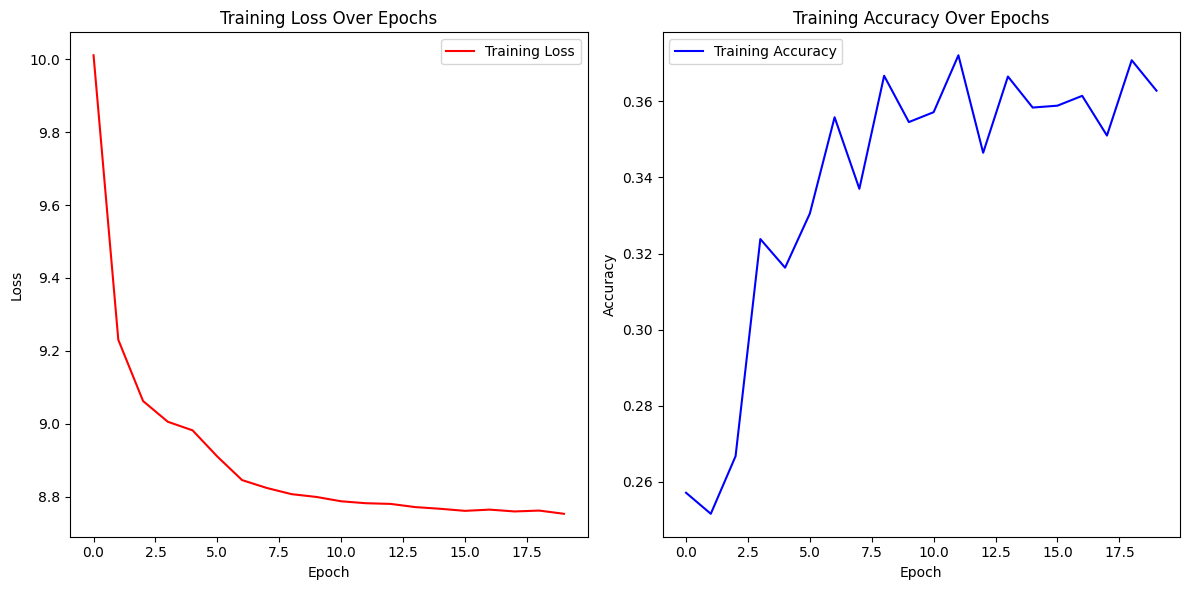

In [130]:
train_loop(model,train_loader,criterion,optimizer,device)

In [131]:
## Inference
def test_loop(model,dataloader,loss_fun,device):
    model.eval()
    model.to(device)
    losses = []
    samples,correct = 0,0
    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
    with torch.no_grad():
        for batch,(x,y) in loop:
            # put on cuda
            x = torch.tensor(x).to(device).long()
            y = torch.tensor(y).to(device).long()

            # forward pass
            y_pred = model(x,y)

            # caclulate test loss
            loss = loss_fun(y_pred.reshape(-1,len(target_vocab)),y.reshape(-1))
            losses.append(loss.detach().item())

            # accuracy over entire dataset
            _,predpos=y_pred.reshape(-1,len(target_vocab)).max(1)
            samples+=len(y.reshape(-1))
            correct+=(predpos==y.reshape(-1)).sum().item()

            # Update TQDM progress bar
            loop.set_postfix(loss=loss.item())

    print("Final Test Accuracy = ",100 * (correct/samples))


In [132]:
test_loop(model,test_loader,criterion,device)

100%|██████████| 145/145 [00:25<00:00,  5.60it/s, loss=9.92]

Final Test Accuracy =  0.3146176185866409


PROBANDO EL MODELO DESPUS DE TERMINAR DE ENTRENAR

In [133]:
# CARGAR EL MODELO PRE ENTRENADO

def load_checkpoint(checkpoint, model, optim):
    print('Loading weights...')
    model.load_state_dict(checkpoint['state_dict'])
    optim.load_state_dict(checkpoint['optimizer'])

# Suponiendo que tienes el archivo 'weights.pth.tar'
checkpoint = torch.load('D:/SIS-421/verano/modelos/nlp_resumen2.pth', map_location=device)
load_checkpoint(checkpoint, model, optimizer)
model.eval()  # Cambiar el modelo a modo de evaluación


Loading weights...


Transformer(
  (encoder_embedding): Embedding(80153, 256)
  (decoder_embedding): Embedding(80153, 256)
  (positional_encoding): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=256, out_features=256, bias=True)
        (W_k): Linear(in_features=256, out_features=256, bias=True)
        (W_v): Linear(in_features=256, out_features=256, bias=True)
        (W_o): Linear(in_features=256, out_features=256, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=256, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=256, bias=True)
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.05, inplace=False)
    )
  )
  (decoder_layers): ModuleList(
    (0-5): 6 x DecoderLayer(
      (self_attn): Mu

In [137]:
# PRE PROCESAR EL TEXTO DE ENTRADA
def preprocess_input(text, tokenizer, stop_words):
    text = cleantext(text)  # Limpia el texto
    tokens = [token.text.lower() for token in tokenizer(text)]  # Tokeniza el texto
    tokens = [word for word in tokens if word not in stop_words]  # Elimina stop words
    return tokens

# Suponiendo que 'nlp' y 'stop_words' ya están definidos, puedes hacer lo siguiente:
input_text = "El mundo es un lugar hermoso para vivir y disfrutar de la vida al máximo con la familia y amigos cercanos en un ambiente tranquilo y pacífico." 
processed_input = preprocess_input(input_text, tokenizer, stop_words)


In [138]:
# CONVERTIR LAS PALABRAS A INDICES DE VOCABULARIO
source_indices = [source_vocab.get(word, 0) for word in processed_input]  # Usa 0 como índice por defecto si la palabra no está en el vocabulario
source_tensor = torch.tensor(source_indices).unsqueeze(0).to(device)  # Agrega una dimensión de batch y envíalo a la GPU


In [140]:
# GENERAR RESUMEN
# Usamos un tensor vacío como "tgt" para inicializar el decodificador
target_tensor = torch.zeros(1, 1).long().to(device)  # Esto es solo un placeholder para comenzar

output = model(source_tensor, target_tensor)

# El output del modelo es un tensor de logits, convertimos a índices de las palabras más probables
_, predicted_indices = output.max(2)

# Convertir los índices de vuelta a palabras
predicted_words = [list(target_vocab.keys())[i] for i in predicted_indices[0].cpu().numpy()]

# Unir las palabras para formar el resumen
generated_summary = ' '.join(predicted_words)
print(generated_summary)


gobierno
